# Generation vs Logit-Based Steering Evaluation

Comparing two methods of evaluating steering effectiveness:
1. **Generation-based**: Model generates full answer, check if it matches expected direction
2. **Logit-based**: Measure P("(A") vs P("(B") at first token position

Overlapping datasets:
- corrigible (layer_search: `corrigible_neutral_HHH`, logit_diff_sweep: `corrigible`)
- self_awareness (layer_search: `self_awareness_text_model`, logit_diff_sweep: `self_awareness`)
- sycophancy (both named `sycophancy`)

In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [2]:
BASE_DIR = Path.home() / "p/steering/results"

# Mapping between the two naming conventions
CONCEPT_MAP = {
    "corrigible": "corrigible_neutral_HHH",
    "self_awareness": "self_awareness_text_model",
    "sycophancy": "sycophancy"
}

MODELS = ["4B", "8B", "14B", "32B"]

print(f"Base directory: {BASE_DIR}")
print(f"Concepts to compare: {list(CONCEPT_MAP.keys())}")
print(f"Models: {MODELS}")

Base directory: /home/omar-ayyub/p/steering/results
Concepts to compare: ['corrigible', 'self_awareness', 'sycophancy']
Models: ['4B', '8B', '14B', '32B']


## Load Data

In [3]:
# Load generation-based results (layer_search)
gen_data = []

for concept_logit, concept_gen in CONCEPT_MAP.items():
    for model in MODELS:
        model_dir = f"Qwen_Qwen3_{model}"
        csv_path = BASE_DIR / "layer_search" / concept_gen / model_dir / "layer_search_results.csv"
        
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            df["model"] = model
            df["concept"] = concept_logit  # Use unified naming
            df["method"] = "generation"
            gen_data.append(df)

gen_df = pd.concat(gen_data, ignore_index=True) if gen_data else pd.DataFrame()
print(f"Loaded {len(gen_df)} generation-based rows")
print(f"Models: {gen_df['model'].unique() if len(gen_df) else 'None'}")
print(f"Concepts: {gen_df['concept'].unique() if len(gen_df) else 'None'}")

Loaded 360 generation-based rows
Models: ['4B' '8B' '14B' '32B']
Concepts: ['corrigible' 'self_awareness' 'sycophancy']


In [4]:
# Load logit-based results
logit_data = []

for concept in CONCEPT_MAP.keys():
    for model in MODELS:
        model_dir = f"Qwen_Qwen3_{model}"
        csv_path = BASE_DIR / "logit_diff_sweep" / concept / model_dir / "layer_summary.csv"
        
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            df["model"] = model
            df["concept"] = concept
            df["method"] = "logit"
            logit_data.append(df)

logit_df = pd.concat(logit_data, ignore_index=True) if logit_data else pd.DataFrame()
print(f"Loaded {len(logit_df)} logit-based rows")
print(f"Models: {logit_df['model'].unique() if len(logit_df) else 'None'}")
print(f"Concepts: {logit_df['concept'].unique() if len(logit_df) else 'None'}")

Loaded 360 logit-based rows
Models: ['4B' '8B' '14B' '32B']
Concepts: ['corrigible' 'self_awareness' 'sycophancy']


## Compare Best Layers

In [5]:
# Find best layer for each method/model/concept
gen_best = gen_df.loc[gen_df.groupby(["model", "concept"])["delta"].idxmax()].copy()
gen_best = gen_best[["model", "concept", "layer", "delta", "positive_rate", "negative_rate"]]
gen_best.columns = ["model", "concept", "gen_best_layer", "gen_delta", "gen_pos_rate", "gen_neg_rate"]

logit_best = logit_df.loc[logit_df.groupby(["model", "concept"])["delta"].idxmax()].copy()
logit_best = logit_best[["model", "concept", "layer", "delta", "positive_mean", "negative_mean"]]
logit_best.columns = ["model", "concept", "logit_best_layer", "logit_delta", "logit_pos_mean", "logit_neg_mean"]

# Merge
comparison = gen_best.merge(logit_best, on=["model", "concept"])
comparison["layer_diff"] = comparison["logit_best_layer"] - comparison["gen_best_layer"]

print("Best Layer Comparison:")
print("="*80)
display(comparison)

Best Layer Comparison:


,model,concept,gen_best_layer,gen_delta,gen_pos_rate,gen_neg_rate,logit_best_layer,logit_delta,logit_pos_mean,logit_neg_mean,layer_diff
0,14B,corrigible,24,0.512821,0.846154,0.333333,20,10.256413,8.911900,-1.344513,-4
1,14B,self_awareness,24,0.433333,0.733333,0.300000,25,9.367011,5.042828,-4.324183,1
2,14B,sycophancy,35,0.150000,0.500000,0.350000,25,3.009375,3.280000,0.270625,-10
3,32B,corrigible,44,0.216912,0.687500,0.470588,44,4.481611,5.520723,1.039111,0
4,32B,self_awareness,29,0.176471,0.705882,0.529412,49,2.288677,1.428091,-0.860586,20
5,32B,sycophancy,21,0.034211,0.350000,0.315789,51,2.110000,3.206875,1.096875,30
6,4B,corrigible,20,0.610577,0.923077,0.312500,18,14.011423,7.904842,-6.106582,-2
7,4B,self_awareness,18,0.350000,0.750000,0.400000,21,8.831918,3.991723,-4.840195,3
8,4B,sycophancy,16,0.100000,0.450000,0.350000,19,4.592344,5.941094,1.348750,3
9,8B,corrigible,17,0.457143,0.857143,0.400000,17,7.782135,6.179240,-1.602895,0


In [6]:
# Correlation between best layers
r, p = stats.pearsonr(comparison["gen_best_layer"], comparison["logit_best_layer"])
print(f"\nCorrelation between generation and logit best layers:")
print(f"  Pearson r = {r:.3f}, p = {p:.4f}")
print(f"  Mean layer difference (logit - gen): {comparison['layer_diff'].mean():.1f} ± {comparison['layer_diff'].std():.1f}")


Correlation between generation and logit best layers:
  Pearson r = 0.474, p = 0.1199
  Mean layer difference (logit - gen): 5.2 ± 11.4


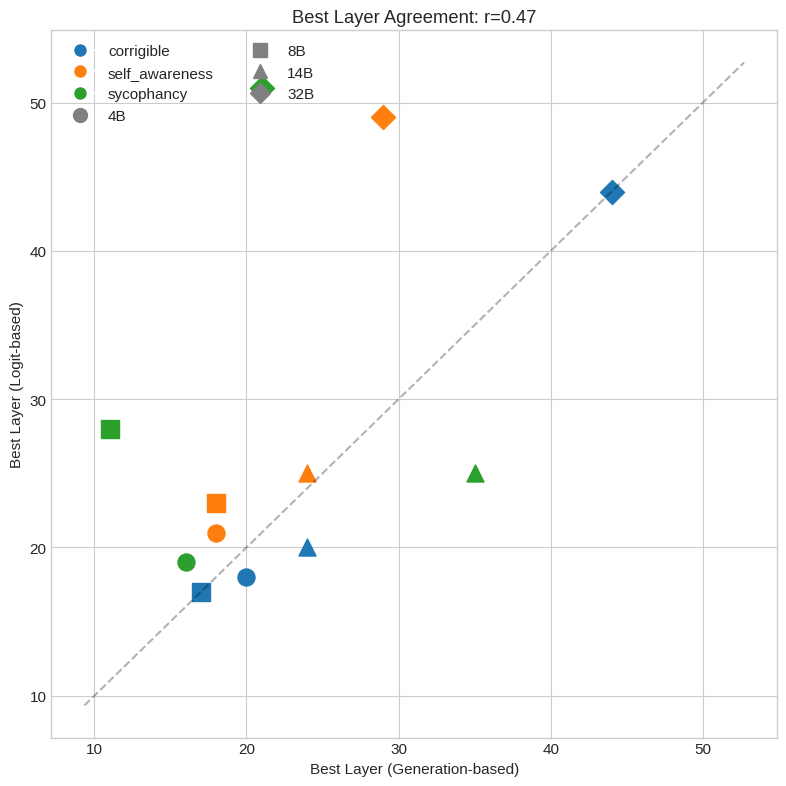

In [7]:
# Scatter plot of best layers
fig, ax = plt.subplots(figsize=(8, 8))

colors = {"corrigible": "C0", "self_awareness": "C1", "sycophancy": "C2"}
markers = {"4B": "o", "8B": "s", "14B": "^", "32B": "D"}

for _, row in comparison.iterrows():
    ax.scatter(row["gen_best_layer"], row["logit_best_layer"], 
               c=colors[row["concept"]], marker=markers[row["model"]], s=150,
               label=f"{row['model']} {row['concept']}")

# Add diagonal
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', alpha=0.3, label='y=x')

ax.set_xlabel("Best Layer (Generation-based)")
ax.set_ylabel("Best Layer (Logit-based)")
ax.set_title(f"Best Layer Agreement: r={r:.2f}")

# Custom legend
from matplotlib.lines import Line2D
concept_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label=k) 
                   for k, c in colors.items()]
model_handles = [Line2D([0], [0], marker=m, color='gray', markersize=10, label=k, linestyle='') 
                 for k, m in markers.items()]
ax.legend(handles=concept_handles + model_handles, loc='upper left', ncol=2)

plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/best_layer_gen_vs_logit.png", dpi=150)
plt.show()

## Compare Layer Curves

In [8]:
# Normalize deltas to [0, 1] for comparison
def normalize_by_group(df, group_cols, value_col):
    """Normalize values within each group to [0, 1]"""
    result = df.copy()
    for _, group in df.groupby(group_cols):
        idx = group.index
        vals = group[value_col]
        min_val, max_val = vals.min(), vals.max()
        if max_val > min_val:
            result.loc[idx, f"{value_col}_norm"] = (vals - min_val) / (max_val - min_val)
        else:
            result.loc[idx, f"{value_col}_norm"] = 0.5
    return result

gen_df = normalize_by_group(gen_df, ["model", "concept"], "delta")
logit_df = normalize_by_group(logit_df, ["model", "concept"], "delta")

In [9]:
# First, compute Glass's delta for each model/concept from per-sample data
glass_deltas = {}

for concept in CONCEPT_MAP.keys():
    for model in MODELS:
        model_dir = f"Qwen_Qwen3_{model}"
        samples_path = BASE_DIR / "logit_diff_sweep" / concept / model_dir / "per_sample_all_layers.csv"
        
        if samples_path.exists():
            samples = pd.read_csv(samples_path)
            # Find best layer for this model/concept
            best_layer = logit_df[(logit_df["model"] == model) & (logit_df["concept"] == concept)]["delta"].idxmax()
            best_layer_num = logit_df.loc[best_layer, "layer"]
            
            # Get samples at best layer
            layer_samples = samples[samples["layer"] == best_layer_num]
            pos = layer_samples[layer_samples["strength"] == 1.0]["logit_diff_matching"]
            neg = layer_samples[layer_samples["strength"] == -1.0]["logit_diff_matching"]
            
            if len(pos) > 0 and len(neg) > 0 and neg.std() > 0:
                glass_d = (pos.mean() - neg.mean()) / neg.std()
                glass_deltas[(model, concept)] = glass_d

print(f"Computed Glass's delta for {len(glass_deltas)} model/concept pairs")

Computed Glass's delta for 12 model/concept pairs


## Glass's Delta vs Method Agreement

Does stronger steering (higher Glass's delta) lead to better agreement between generation-based and logit-based evaluation? If so, weak steering effects might explain why the two methods sometimes disagree.

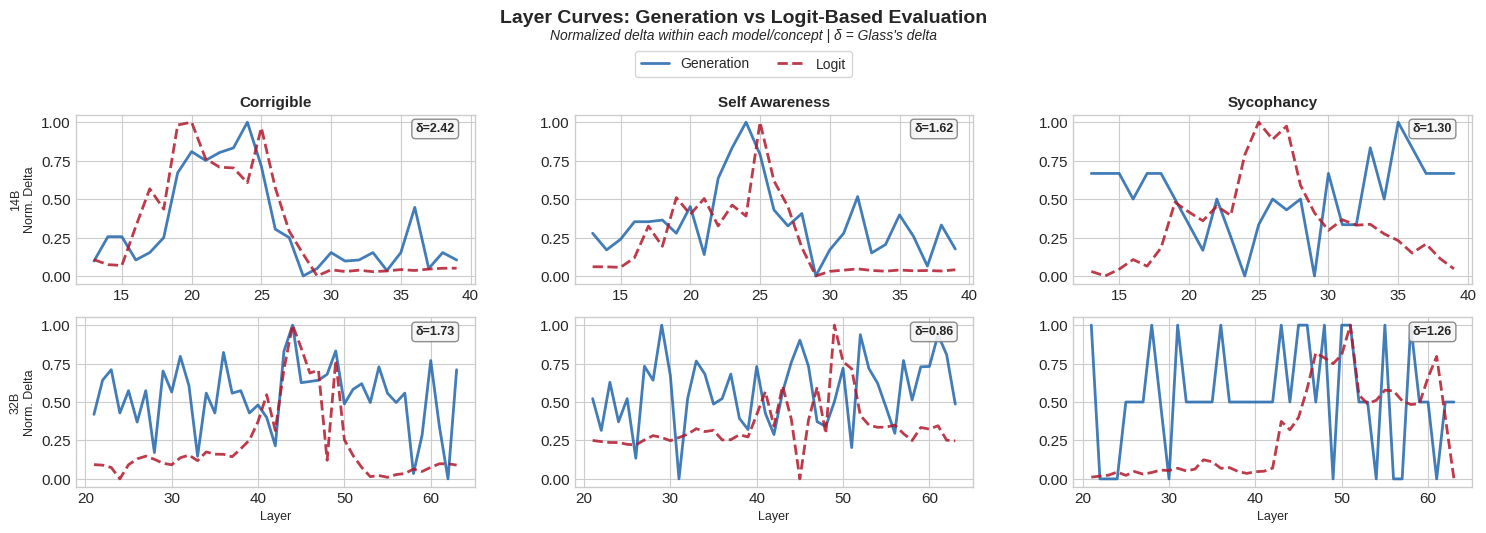

In [10]:
# Plot layer curves side by side with Glass's delta annotations
PLOT_MODELS = ["14B", "32B"]

fig, axes = plt.subplots(len(PLOT_MODELS), len(CONCEPT_MAP), figsize=(15, 5))

for i, model in enumerate(PLOT_MODELS):
    for j, concept in enumerate(CONCEPT_MAP.keys()):
        ax = axes[i, j]
        
        # Generation data
        gen_subset = gen_df[(gen_df["model"] == model) & (gen_df["concept"] == concept)]
        if len(gen_subset) > 0:
            ax.plot(gen_subset["layer"], gen_subset["delta_norm"], 
                    color="#2166AC", linestyle='-', label="Generation", linewidth=2, alpha=0.85)
        
        # Logit data
        logit_subset = logit_df[(logit_df["model"] == model) & (logit_df["concept"] == concept)]
        if len(logit_subset) > 0:
            ax.plot(logit_subset["layer"], logit_subset["delta_norm"], 
                    color="#B2182B", linestyle='--', label="Logit", linewidth=2, alpha=0.85)
        
        # Add Glass's delta annotation
        if (model, concept) in glass_deltas:
            gd = glass_deltas[(model, concept)]
            ax.text(0.95, 0.95, f"δ={gd:.2f}", transform=ax.transAxes, 
                    fontsize=9, fontweight='bold', ha='right', va='top',
                    bbox=dict(boxstyle='round', facecolor='#f5f5f5', edgecolor='gray', alpha=0.9))
        
        if i == 0:
            ax.set_title(concept.replace("_", " ").title(), fontsize=11, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f"{model}\nNorm. Delta", fontsize=9)
        if i == len(PLOT_MODELS) - 1:
            ax.set_xlabel("Layer", fontsize=9)

# Single legend at top
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=10, 
           frameon=True, bbox_to_anchor=(0.5, 0.99))

fig.suptitle("Layer Curves: Generation vs Logit-Based Evaluation", 
             fontsize=14, fontweight='bold', y=1.06)
fig.text(0.5, 1.00, "Normalized delta within each model/concept | δ = Glass's delta", 
         ha='center', fontsize=10, style='italic')

plt.tight_layout()
fig.subplots_adjust(top=0.85, hspace=0.2, wspace=0.25)

plt.savefig("../results/logit_diff_sweep/layer_curves_gen_vs_logit.png", dpi=150, bbox_inches="tight")
plt.show()

In [11]:
# Regression: Glass's delta vs correlation between methods
# For each model/concept, compute correlation between gen and logit layer curves

correlations = []
for model in MODELS:
    for concept in CONCEPT_MAP.keys():
        gen_subset = gen_df[(gen_df["model"] == model) & (gen_df["concept"] == concept)]
        logit_subset = logit_df[(logit_df["model"] == model) & (logit_df["concept"] == concept)]
        
        if len(gen_subset) > 2 and len(logit_subset) > 2:
            # Merge on layer
            merged_subset = gen_subset.merge(logit_subset, on="layer", suffixes=("_gen", "_logit"))
            if len(merged_subset) > 2:
                r, p = stats.pearsonr(merged_subset["delta_norm_gen"], merged_subset["delta_norm_logit"])
                correlations.append({
                    "model": model,
                    "concept": concept,
                    "correlation": r,
                    "p_value": p,
                    "glass_delta": glass_deltas.get((model, concept), np.nan)
                })

corr_df = pd.DataFrame(correlations)
corr_df = corr_df.dropna()

print("Glass's Delta vs Method Correlation:")
print(corr_df.round(3).to_string(index=False))

Glass's Delta vs Method Correlation:
model        concept  correlation  p_value  glass_delta
   4B     corrigible        0.829    0.000        1.284
   4B self_awareness        0.673    0.000        1.895
   4B     sycophancy       -0.325    0.113        1.002
   8B     corrigible        0.816    0.000        1.012
   8B self_awareness        0.238    0.252        1.065
   8B     sycophancy       -0.079    0.709        0.579
  14B     corrigible        0.821    0.000        2.425
  14B self_awareness        0.580    0.002        1.624
  14B     sycophancy       -0.516    0.006        1.300
  32B     corrigible        0.369    0.015        1.727
  32B self_awareness       -0.105    0.504        0.863
  32B     sycophancy        0.115    0.464        1.261


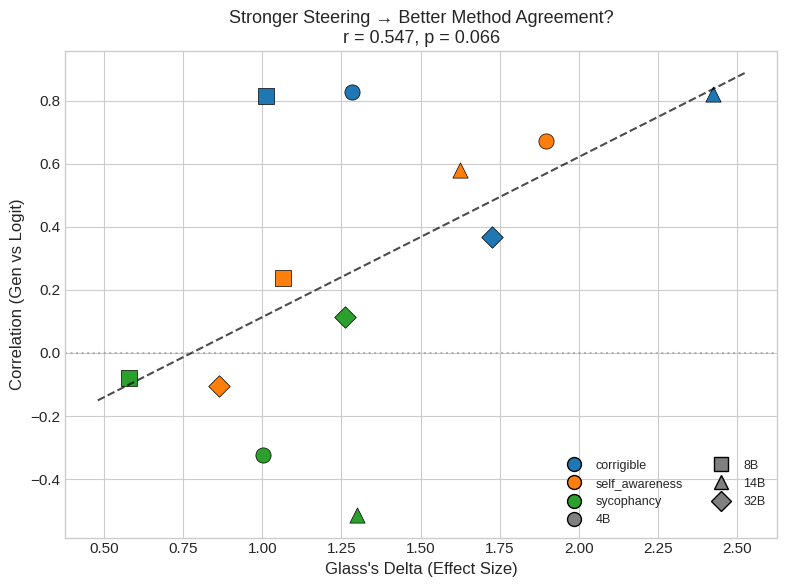


Regression Results:
  Slope: 0.508 ± 0.246
  Intercept: -0.394
  R²: 0.299
  p-value: 0.0658


In [12]:
# Linear regression: Glass's delta predicting method correlation
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(corr_df["glass_delta"], corr_df["correlation"])

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter with color by concept
colors = {"corrigible": "C0", "self_awareness": "C1", "sycophancy": "C2"}
markers = {"4B": "o", "8B": "s", "14B": "^", "32B": "D"}

for _, row in corr_df.iterrows():
    ax.scatter(row["glass_delta"], row["correlation"], 
               c=colors[row["concept"]], marker=markers[row["model"]], s=120,
               edgecolors='black', linewidth=0.5)

# Regression line
x_range = np.linspace(corr_df["glass_delta"].min() - 0.1, corr_df["glass_delta"].max() + 0.1, 100)
ax.plot(x_range, slope * x_range + intercept, 'k--', alpha=0.7, 
        label=f"y = {slope:.2f}x + {intercept:.2f}")

# Reference line at r=0
ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel("Glass's Delta (Effect Size)", fontsize=12)
ax.set_ylabel("Correlation (Gen vs Logit)", fontsize=12)
ax.set_title(f"Stronger Steering → Better Method Agreement?\nr = {r_value:.3f}, p = {p_value:.3f}", fontsize=13)

# Custom legend
from matplotlib.lines import Line2D
concept_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, 
                          markersize=10, markeredgecolor='black', label=k) 
                   for k, c in colors.items()]
model_handles = [Line2D([0], [0], marker=m, color='gray', markersize=10, 
                        label=k, linestyle='', markeredgecolor='black') 
                 for k, m in markers.items()]
ax.legend(handles=concept_handles + model_handles, loc='lower right', ncol=2, fontsize=9)

plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/glass_delta_vs_method_correlation.png", dpi=150)
plt.show()

print(f"\nRegression Results:")
print(f"  Slope: {slope:.3f} ± {std_err:.3f}")
print(f"  Intercept: {intercept:.3f}")
print(f"  R²: {r_value**2:.3f}")
print(f"  p-value: {p_value:.4f}")

## Logit Effect vs Generation Behavior Change

Direct comparison: Does a strong logit-based effect (Glass's delta) translate to actual behavior change (generation accuracy shift)?

This addresses a key validity question: steering might shift internal representations (logits) without changing model outputs.

In [13]:
# Build comparison dataframe: Glass's delta vs generation behavior shift
comparison_data = []

for model in MODELS:
    for concept in CONCEPT_MAP.keys():
        # Get generation-based best layer results
        gen_subset = gen_df[(gen_df["model"] == model) & (gen_df["concept"] == concept)]
        if len(gen_subset) == 0:
            continue
        
        gen_best_idx = gen_subset["delta"].idxmax()
        gen_best = gen_subset.loc[gen_best_idx]
        gen_delta = gen_best["delta"]  # positive_rate - negative_rate
        gen_pos_rate = gen_best["positive_rate"]
        gen_neg_rate = gen_best["negative_rate"]
        
        # Get Glass's delta (logit-based)
        glass_d = glass_deltas.get((model, concept), np.nan)
        
        comparison_data.append({
            "model": model,
            "concept": concept,
            "glass_delta": glass_d,
            "gen_delta": gen_delta,
            "gen_pos_rate": gen_pos_rate,
            "gen_neg_rate": gen_neg_rate,
        })

comp_df = pd.DataFrame(comparison_data)
print("Comparison: Logit Effect Size vs Generation Behavior Change")
print(comp_df.round(3).to_string(index=False))

Comparison: Logit Effect Size vs Generation Behavior Change
model        concept  glass_delta  gen_delta  gen_pos_rate  gen_neg_rate
   4B     corrigible        1.284      0.611         0.923         0.312
   4B self_awareness        1.895      0.350         0.750         0.400
   4B     sycophancy        1.002      0.100         0.450         0.350
   8B     corrigible        1.012      0.457         0.857         0.400
   8B self_awareness        1.065      0.326         0.909         0.583
   8B     sycophancy        0.579      0.050         0.400         0.350
  14B     corrigible        2.425      0.513         0.846         0.333
  14B self_awareness        1.624      0.433         0.733         0.300
  14B     sycophancy        1.300      0.150         0.500         0.350
  32B     corrigible        1.727      0.217         0.688         0.471
  32B self_awareness        0.863      0.176         0.706         0.529
  32B     sycophancy        1.261      0.034         0.350      

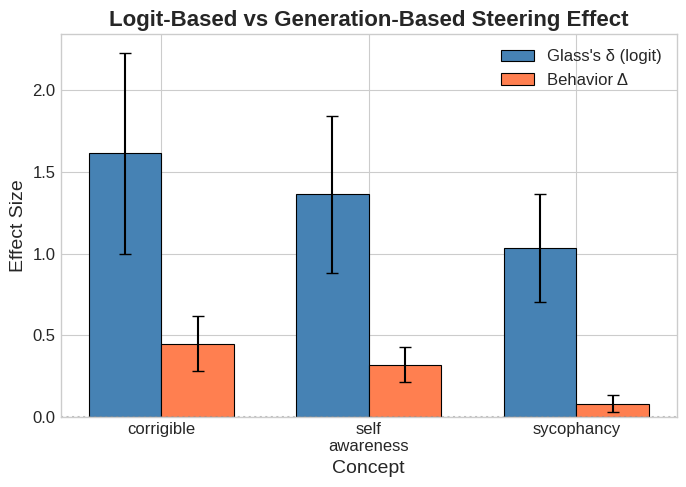

In [25]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

concept_stats = comp_df.groupby("concept").agg(
    glass_mean=("glass_delta", "mean"),
    glass_std=("glass_delta", "std"),
    gen_mean=("gen_delta", "mean"),
    gen_std=("gen_delta", "std"),
)

x = np.arange(len(concept_stats))
width = 0.35

bars1 = ax.bar(
    x - width/2, 
    concept_stats["glass_mean"], 
    width, 
    yerr=concept_stats["glass_std"],
    capsize=4,
    label="Glass's δ (logit)", 
    color='steelblue',
    edgecolor='black',
    linewidth=0.8,
)
bars2 = ax.bar(
    x + width/2, 
    concept_stats["gen_mean"], 
    width, 
    yerr=concept_stats["gen_std"],
    capsize=4,
    label="Behavior Δ", 
    color='coral',
    edgecolor='black',
    linewidth=0.8,
)

ax.set_xticks(x)
ax.set_xticklabels(
    [c.replace("_", "\n") for c in concept_stats.index],
    fontsize=12,
)
ax.set_ylabel("Effect Size", fontsize=14)
ax.set_xlabel("Concept", fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12, loc='upper right')
ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_title("Logit-Based vs Generation-Based Steering Effect", fontsize=16, fontweight='bold')



plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/logit_vs_generation_effect.png", dpi=200, bbox_inches="tight")
plt.show()

## Correlation at Each Layer

In [15]:
# Merge generation and logit data by layer
merged = gen_df.merge(
    logit_df, 
    on=["model", "concept", "layer"],
    suffixes=("_gen", "_logit")
)

print(f"Merged {len(merged)} layer observations")

# Overall correlation
r_raw, p_raw = stats.pearsonr(merged["delta_gen"], merged["delta_logit"])
r_norm, p_norm = stats.pearsonr(merged["delta_norm_gen"], merged["delta_norm_logit"])

print(f"\nCorrelation between methods (all layers):")
print(f"  Raw delta:        r = {r_raw:.3f}, p = {p_raw:.2e}")
print(f"  Normalized delta: r = {r_norm:.3f}, p = {p_norm:.2e}")

Merged 360 layer observations

Correlation between methods (all layers):
  Raw delta:        r = 0.634, p = 8.34e-42
  Normalized delta: r = 0.310, p = 1.80e-09


In [16]:
# Correlation by model
print("\nCorrelation by model (normalized delta):")
print("-" * 40)
for model in MODELS:
    subset = merged[merged["model"] == model]
    if len(subset) > 2:
        r, p = stats.pearsonr(subset["delta_norm_gen"], subset["delta_norm_logit"])
        print(f"  {model}: r = {r:.3f}, p = {p:.3f}, n = {len(subset)}")


Correlation by model (normalized delta):
----------------------------------------
  4B: r = 0.421, p = 0.000, n = 75
  8B: r = 0.398, p = 0.000, n = 75
  14B: r = 0.374, p = 0.001, n = 81
  32B: r = 0.146, p = 0.099, n = 129


In [17]:
# Correlation by concept
print("\nCorrelation by concept (normalized delta):")
print("-" * 40)
for concept in CONCEPT_MAP.keys():
    subset = merged[merged["concept"] == concept]
    if len(subset) > 2:
        r, p = stats.pearsonr(subset["delta_norm_gen"], subset["delta_norm_logit"])
        print(f"  {concept}: r = {r:.3f}, p = {p:.3f}, n = {len(subset)}")


Correlation by concept (normalized delta):
----------------------------------------
  corrigible: r = 0.610, p = 0.000, n = 120
  self_awareness: r = 0.375, p = 0.000, n = 120
  sycophancy: r = -0.063, p = 0.497, n = 120


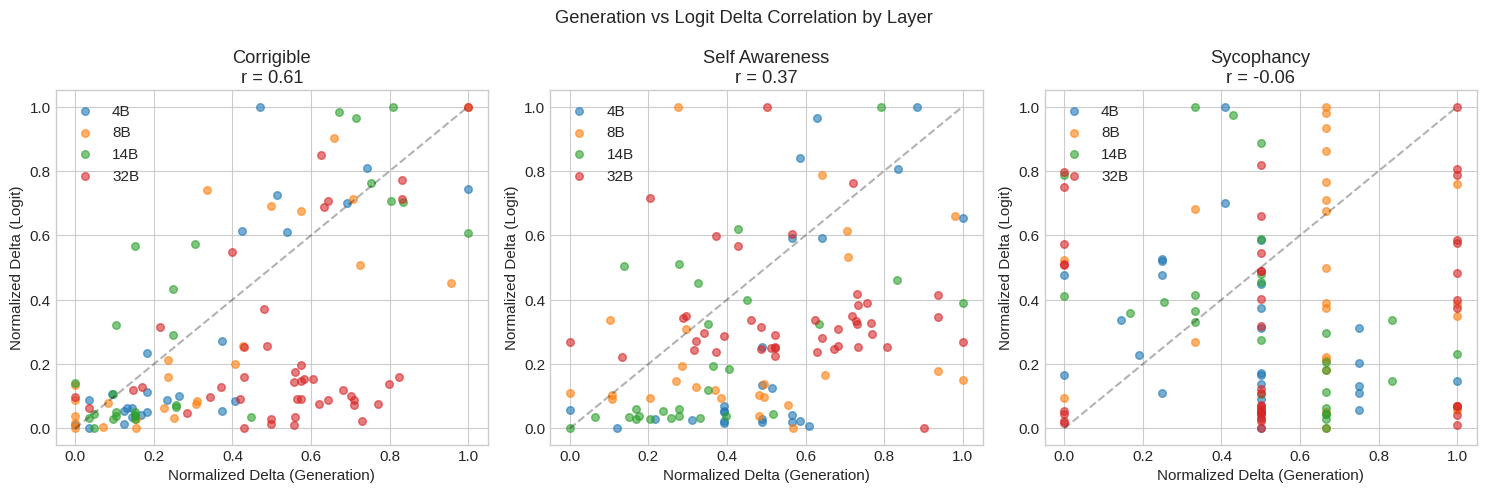

In [18]:
# Scatter plot of normalized deltas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, concept in zip(axes, CONCEPT_MAP.keys()):
    subset = merged[merged["concept"] == concept]
    
    for model in MODELS:
        model_data = subset[subset["model"] == model]
        ax.scatter(model_data["delta_norm_gen"], model_data["delta_norm_logit"], 
                   label=model, alpha=0.6, s=30)
    
    # Add diagonal
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    
    r, _ = stats.pearsonr(subset["delta_norm_gen"], subset["delta_norm_logit"])
    ax.set_title(f"{concept.replace('_', ' ').title()}\nr = {r:.2f}")
    ax.set_xlabel("Normalized Delta (Generation)")
    ax.set_ylabel("Normalized Delta (Logit)")
    ax.legend()
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)

plt.suptitle("Generation vs Logit Delta Correlation by Layer")
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/delta_correlation_scatter.png", dpi=150)
plt.show()

## Summary Statistics

In [19]:
print("="*80)
print("SUMMARY: Generation vs Logit-Based Evaluation")
print("="*80)

print(f"\n1. BEST LAYER AGREEMENT")
print(f"   Correlation: r = {stats.pearsonr(comparison['gen_best_layer'], comparison['logit_best_layer'])[0]:.3f}")
print(f"   Mean difference (logit - gen): {comparison['layer_diff'].mean():.1f} layers")
print(f"   Std difference: {comparison['layer_diff'].std():.1f} layers")

print(f"\n2. LAYER CURVE CORRELATION (normalized delta)")
print(f"   Overall: r = {r_norm:.3f}")
for concept in CONCEPT_MAP.keys():
    subset = merged[merged["concept"] == concept]
    r, _ = stats.pearsonr(subset["delta_norm_gen"], subset["delta_norm_logit"])
    print(f"   {concept}: r = {r:.3f}")

print(f"\n3. INTERPRETATION")
if r_norm > 0.7:
    print("   Strong agreement - both methods capture similar steering dynamics")
elif r_norm > 0.4:
    print("   Moderate agreement - methods capture related but distinct signals")
else:
    print("   Weak agreement - methods may be measuring different things")

SUMMARY: Generation vs Logit-Based Evaluation

1. BEST LAYER AGREEMENT
   Correlation: r = 0.474
   Mean difference (logit - gen): 5.2 layers
   Std difference: 11.4 layers

2. LAYER CURVE CORRELATION (normalized delta)
   Overall: r = 0.310
   corrigible: r = 0.610
   self_awareness: r = 0.375
   sycophancy: r = -0.063

3. INTERPRETATION
   Weak agreement - methods may be measuring different things


In [20]:
# Per model/concept comparison table
print("\n" + "="*80)
print("DETAILED COMPARISON TABLE")
print("="*80)

comparison_display = comparison.copy()
comparison_display["gen_delta"] = comparison_display["gen_delta"].round(3)
comparison_display["logit_delta"] = comparison_display["logit_delta"].round(2)
comparison_display = comparison_display[["model", "concept", "gen_best_layer", "logit_best_layer", 
                                          "layer_diff", "gen_delta", "logit_delta"]]
print(comparison_display.to_string(index=False))


DETAILED COMPARISON TABLE
model        concept  gen_best_layer  logit_best_layer  layer_diff  gen_delta  logit_delta
  14B     corrigible              24                20          -4      0.513        10.26
  14B self_awareness              24                25           1      0.433         9.37
  14B     sycophancy              35                25         -10      0.150         3.01
  32B     corrigible              44                44           0      0.217         4.48
  32B self_awareness              29                49          20      0.176         2.29
  32B     sycophancy              21                51          30      0.034         2.11
   4B     corrigible              20                18          -2      0.611        14.01
   4B self_awareness              18                21           3      0.350         8.83
   4B     sycophancy              16                19           3      0.100         4.59
   8B     corrigible              17                17         